# 가격 예측 모델

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_89 (LSTM)               (None, 50, 50)            10400     
_________________________________________________________________
lstm_90 (LSTM)               (None, 64)                29440     
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________
Train on 818 samples, validate on 44 samples
Epoch 1/20
818/818 [==============================] - 5s 7ms/step - loss: 0.0291 - val_loss: 0.0031
Epoch 2/20
818/818 [==============================] - 5s 6ms/step - loss: 0.0173 - val_loss: 0.0029
Epoch 3/20
818/818 [==============================] - 5s 6ms/step - loss: 0.0141 - val_loss: 0.0025
Epoch 4/20
818/818 [==============

820/820 [==============================] - 4s 5ms/step - loss: 0.0046 - val_loss: 9.0410e-04
Epoch 14/20
820/820 [==============================] - 4s 5ms/step - loss: 0.0042 - val_loss: 8.8510e-04
Epoch 15/20
820/820 [==============================] - 4s 5ms/step - loss: 0.0042 - val_loss: 8.1011e-04
Epoch 16/20
820/820 [==============================] - 4s 5ms/step - loss: 0.0042 - val_loss: 8.1849e-04
Epoch 17/20
820/820 [==============================] - 4s 5ms/step - loss: 0.0038 - val_loss: 7.0645e-04
Epoch 18/20
820/820 [==============================] - 5s 6ms/step - loss: 0.0041 - val_loss: 0.0014
Epoch 19/20
820/820 [==============================] - 4s 5ms/step - loss: 0.0038 - val_loss: 0.0011
Epoch 20/20
1/1 [==============================] - 0s 8ms/step
## evaluation loss and_metrics ##
0.8223634958267212
----------------------------------------------------------------------------------
# 3 , [P]Price: 8,670,775  ====> Data: [9561500.] [-0.09315742]
Model: "sequential_49"

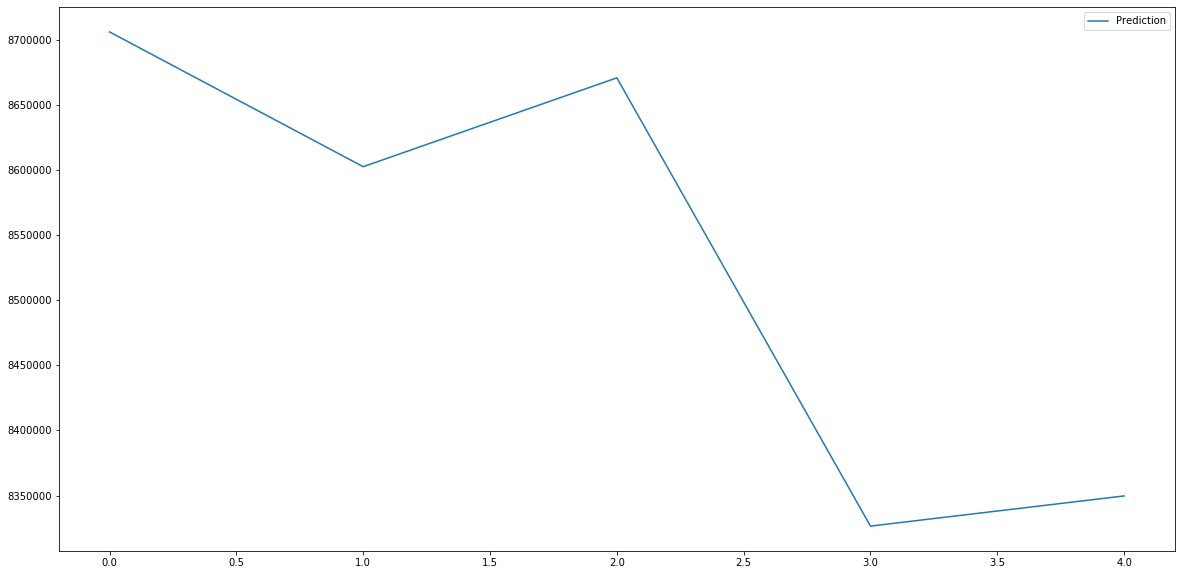

In [52]:
#노트
#훈련데이터 랜덤 셔플링은 효과가 적음




#1)사용할 패키지 선언

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import datetime

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation


#변수 정의

price_data = []         #예측 가젹 데이터
window_data_set = []    #윈도우 데이터 
normal_data_set=[]      #정규화 데이터
pred_price_data =[]     #예측가격 데이터
real_price_data =[]     #실제가격 데이터

pred_price=0



today = datetime.date.today()
last_date = today.strftime('%Y-%m-%d')



#2)데이터 불러오기

#raw_data = fdr.DataReader('ETH/KRW', '2015')   #코인
raw_data = fdr.DataReader('BTC/KRW', '2015')   #코인
#raw_data = fdr.DataReader('005930', '2014')  #주식 - 국내
#raw_data = fdr.DataReader('AAPL', '2018-01-01', '2019-11-20') #주식-미국

raw_data.tail(10) #최근 10개 데이터 표시
raw_data.head(10) #과거 10개 데이터 표시


#3)데이터 세트 만들기

high_prices = raw_data['High'].values                #상한가 데이터
low_prices = raw_data['Low'].values                  #하한가 데이터
close_prices = raw_data['Close'].values              #종가 데이터
mid_prices = (high_prices + low_prices) / 2         #중간가 데이터

#----------------------------------------------------------------------------------------
#4)사용할 데이터셑 셑팅

price_data =  mid_prices            #high_prices ,low_prices, mid_prices, close_prices

parameter_seq_len = 50             #학습 데이터 기간
parameter_epochs_len = 20           #학습 횟수
parameter_forecast_len = 5         #예측 기간

parameter_todaydata_flag = True         #오늘 데이터 포함 여부(ex. 코인의 경우. 예측 날짜 데이터 포함)
parameter_pred_flag = True              #예측 여부. False일 경우 모델 검증
#-----------------------------------------------------------------------------------------


#4-1)Function 정의
#window 생성 : X일 데이터로 다음날 하루 예측

def make_windows(data,seq):
    
    result_windows=[]
    sequence_length = seq + 1
    
    for index in range(len(data) - seq): 
        result_windows.append(data[index: index + sequence_length]) # seq_len+1 에는 결과 값 저장
        
    return np.array(result_windows)

#데이터 정규화 => 훈련 정확도 향상

def normalize_windows(data):
    
    normalized_data = []
    
    for window in data:
        normalized_window = [((float(p) / float(window[0])) - 1) for p in window ]
        normalized_data.append(normalized_window)

    return np.array(normalized_data)


#Day+1 데이터 추가 => 윈도우 생성시 필요

if parameter_todaydata_flag==False: 
    price_data = np.hstack((price_data, 0)) # 임시 데이터 추가:결과값을 0으로 셑팅


if parameter_pred_flag==False:
    parameter_forecast_len=1   #훈련 모드
    
    
i=1
    
    
while i<= parameter_forecast_len:
    
    
    #윈도우 데이터 생성
    window_data_set = make_windows(price_data,parameter_seq_len)

    #윈도우 데이터 정규화
    normal_data_set = normalize_windows(window_data_set)
    
    
    #훈련 데이터 설정
    if parameter_pred_flag==True:
        row = len(normal_data_set)-1
    else:
        row = int(round(normal_data_set.shape[0] * 0.9)) #90% 훈련, 10% 검증(테스트)
        test_row = len(normal_data_set) - row
    
    train = normal_data_set[:row, :] #전체 중 row 만큼 데이터 저장 => 훈련 데이터로
    
    #np.random.shuffle(train)    #훈련 데이터 랜덤서플링

    x_train = train[:, :-1] 
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))   #행 개수, 열 개수 => 예측 데이터 셑
    y_train = train[:, -1] # 마지막 열 데이터  ==> 실제 값

    x_test = normal_data_set[row:, :-1]
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    y_test = normal_data_set[row:, -1]

    model = Sequential()
    model.add(LSTM(parameter_seq_len, return_sequences=True, input_shape=(parameter_seq_len, 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(1, activation='linear')) #다음날 하루 
    model.compile(loss='mse', optimizer='rmsprop')
    model.summary()

    start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
    
    his=model.fit(x_train, y_train,
        batch_size=10,
        epochs=parameter_epochs_len,
        validation_split=0.05)

    pred = model.predict(x_test)     #D+1 예측 결과
    
    loss_and_metrics = model.evaluate(x_test, y_test, batch_size=10)
    print('## evaluation loss and_metrics ##')
    print(loss_and_metrics)
    
    pred_cnt=0
    pred_good=0
    
    for pred_val in pred:
        

        de_x_test =  window_data_set[row:, :-1]  #역정규화 데이터 추출
        de_x_test = np.reshape(de_x_test, (de_x_test.shape[0], de_x_test.shape[1], 1))

        de_normal_price = de_x_test[pred_cnt,0]
        pred_price = int(de_normal_price*(pred_val+1))  #예측 가격 = 예측데이터 D0 가격(역정규화)*예측값
        pred_price_data.append(pred_price)
        
        if parameter_pred_flag==True:
            
            price_data=price_data[:len(price_data)-1]  #최종 값은 원천 데이터에서 삭제 => 윈도우 생성시에만 필요
                
            print("----------------------------------------------------------------------------------")
            print("#",i,", [P]Price:", format(pred_price, ',')," ====> Data:",de_normal_price ,pred_val,sep=" ", end="\n")

        
        else:
            
            real_price = price_data[len(price_data)-test_row+pred_cnt]
            real_price_data.append(real_price)
            
            if (1-real_price/pred_price >= -0.01) and (1-real_price/pred_price <= 0.01):
                pred_good = pred_good + 1
            
            #print("----------------------------------------------------------------------------------")      
            #print("#",pred_cnt+1,", [R]Price:",format(real_price, ','), ", [P]Price:", format(pred_price, ','),", Gap:" ,format(pred_price-real_price,','),"=> %0.2f%%"%(float(1-real_price/pred_price)*100)," ====> Data:",de_normal_price,pred_val,sep=" ", end="\n")
    
        pred_cnt=pred_cnt+1
    
    if parameter_pred_flag==True:
    
        #예측값 추가
        price_data = np.hstack((price_data, pred_price)) #Day++ 예측데이터 추가

        #데이터셑 재 정의(Day++)

        price_data = np.hstack((price_data, 0)) # 임시 데이터 추가:결과값을 0으로 셑팅
        
    else:
        print("========>Score(+- 1%):","%0.2f%%"%(float(pred_good/pred_cnt)*100))

    i=i+1


if parameter_pred_flag==True:    
    print(pred_price_data)
    fig = plt.figure(facecolor='white', figsize=(20, 10))
    ax = fig.add_subplot(111)
    ax.plot(pred_price_data, label='Prediction')
    ax.legend()
    plt.show()
else:
    fig = plt.figure(facecolor='white', figsize=(20, 10))
    ax = fig.add_subplot(111)
    ax.plot(y_test, label='True')
    ax.plot(pred, label='Prediction')
    ax.legend()
    plt.show()
    
    fig = plt.figure(facecolor='white', figsize=(20, 10))
    ax = fig.add_subplot(111)
    ax.plot(real_price_data, label='True')
    ax.plot(pred_price_data, label='Prediction')
    ax.legend()
    plt.show()



In [53]:
raw_data.tail(10) 

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2019-11-14,10075000,10222000,10242000,10039000,2880.0,-0.0137
2019-11-15,9921000,10082000,10220000,9859000,1330.0,-0.0153
2019-11-16,9929000,9925000,9994000,9883000,990.0,0.0008
2019-11-17,9928000,9929000,10050000,9829000,2240.0,-0.0001
2019-11-18,9590000,9926000,9927000,9525000,2670.0,-0.0340
2019-11-19,9516000,9587000,9612000,9364000,1040.0,-0.0077
2019-11-20,9481000,9516000,9599000,9415000,1080.0,-0.0037
2019-11-21,9034000,9483000,9532000,8931000,3100.0,-0.0471
2019-11-22,8667000,9037000,9129000,8195000,4520.0,-0.0406


TypeError: tail() takes from 1 to 2 positional arguments but 3 were given